# Lensing maps

Data can be found at https://ulagam-simulations.readthedocs.io/en/latest/data_products.html#lensing-convergence-shells

In GLOBUS, we can find the simulations at Collection : Qiijote_simulations2 with path /Ulagam/fiducial/0/pkdgrav_output/



In [1]:
import numpy as np
import healpy as hp
from tqdm import tqdm
from astropy.cosmology import z_at_value, FlatwCDM
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from scipy import interpolate
import glob

def get_param(log_file_name, parameter_name):
    with open(log_file_name, "r") as f:
        for line in f:
            if parameter_name in line:
                tokenised_string = line.split(" ")
                for (token, i) in zip(tokenised_string, range(len(tokenised_string))):
                    if token == parameter_name or token == (parameter_name + ":"):
                        if i < len(tokenised_string) - 1:
                            return float(tokenised_string[i + 1])    


def load_densities(InputDir):
    
    sim_filenames = glob.glob(InputDir + '/Density_shell*fits.fz')
    sim_filenames = sorted(sim_filenames)
    #sim_filenames = sim_filenames[:-1] #Remove the 00100 shell
    #sim_filenames = sim_filenames[::-1]

    #Else/then load density maps
    overdensity_array = np.zeros((len(sim_filenames), hp.nside2npix(1024)), dtype=np.float32)
    for i in tqdm(range(overdensity_array.shape[0])):
        map_read = fits.open(sim_filenames[i])[1].data
        overdensity_array[i] = map_read/np.mean(map_read)-1
    
    return overdensity_array


def make_kappa(overdensity_array, a_centre, comoving_edges):

    dr_array = comoving_edges[1:] - comoving_edges[:-1]
    comoving_max = comoving_edges[-1]
    comoving_centre = 0.5*(comoving_edges[:-1] + comoving_edges[1:])

    #Lensing efficiency kernel
    comoving_prefactors = dr_array * (comoving_max - comoving_centre) * comoving_centre / (comoving_max * a_centre)
    
    K = 0
    for i in range(overdensity_array.shape[0]):
        K += comoving_prefactors[i]*overdensity_array[i]
        
    return K


def make_shells(InputDir):

    d = load_densities(InputDir)

    log = np.genfromtxt(InputDir +  '/Density_shell.log')
    z_bin_edges = log.T[1][::-1] #Reverse

    # cosmo code
    om = get_param(InputDir +  '/Density_shell.log', 'dOmega0') # 0.3175
    s8 = get_param(InputDir +  '/Density_shell.log', 'dSigma8') # 0.834
    h  = get_param(InputDir +  '/Density_shell.log', 'h') # 0.6711
    w0 = get_param(InputDir +  '/Density_shell.log', 'w0') # -1

    cosmo_fiducial = FlatwCDM(H0= h * 100. * u.km / u.s / u.Mpc, Om0 = om, w0 = w0)
    comoving_edges = cosmo_fiducial.comoving_distance(z_bin_edges)

    z    = np.linspace(min(z_bin_edges), max(z_bin_edges), 10_000)
    dist = cosmo_fiducial.comoving_distance(z).value
    reverse_interp  = interpolate.CubicSpline(dist, z)

    comoving_edges  = cosmo_fiducial.comoving_distance(z_bin_edges).value
    comoving_center = (comoving_edges[1:] + comoving_edges[:-1])/2
    z_centre        = reverse_interp(comoving_center) #Get redshift at the central radius of each radial shell

    kappa_lensing  = np.zeros([len(d), hp.nside2npix(1024)], dtype=np.float32)


    for i in tqdm(range(len(d))):
        kappa_lensing[i, :] = make_kappa(overdensity_array=d[:i+1], 
                                         a_centre=1./(1.+z_centre[:i+1]), 
                                         comoving_edges=comoving_edges[:i+2])
        
        
    H0 = h * 100. * u.km / u.s / u.Mpc
    bit_with_units  = H0.to(u.s ** -1)/const.c.to('Mpc/s')
    kappa_prefactor = (3/2 * om * bit_with_units * bit_with_units).value 
    
    kappa_lensing *= kappa_prefactor

    return kappa_lensing

In [2]:
InputDir = '/travail/lmousset/Ulagam/'

In [3]:
from astropy.io import fits
import numpy as np

counts = fits.open('/travail/lmousset/Ulagam/Density_shell.00010.fits.fz')[1].data

In [4]:
kappa_lensing = make_shells(InputDir)

100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


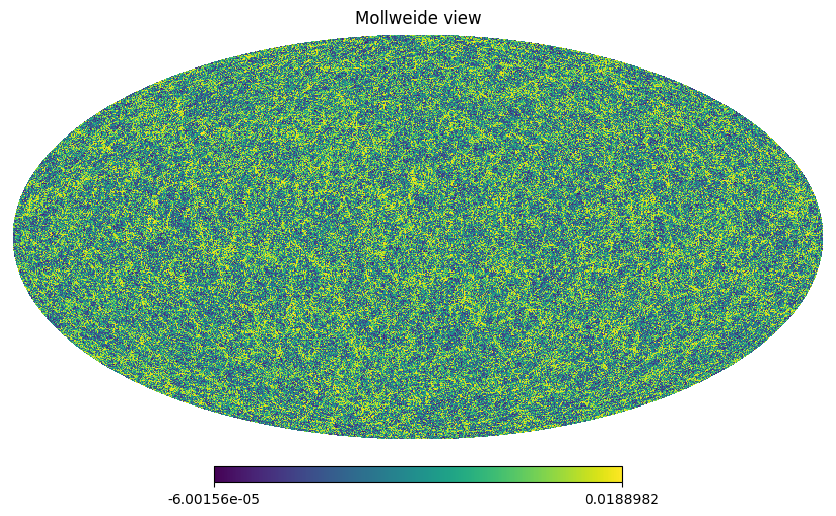

In [5]:
hp.mollview(kappa_lensing[2], norm='hist')

In [143]:
hp.fitsfunc.write_map(InputDir+'kappa_00099.fits', kappa_lensing[2])

setting the output map dtype to [dtype('float32')]


In [39]:
import scatcovjax.Sphere_lib as sphlib
toto = fits.open(InputDir+'kappa_00099.fits')
I = hp.read_map(toto)

I = hp.ud_grade(I, nside_out=128)
#I = np.log(I + 0.0001) - 2
I = sphlib.normalize_map(I)

Mean and STD: 0.000 and 1.000


In [40]:
nside = hp.get_nside(I)
print(nside)

128


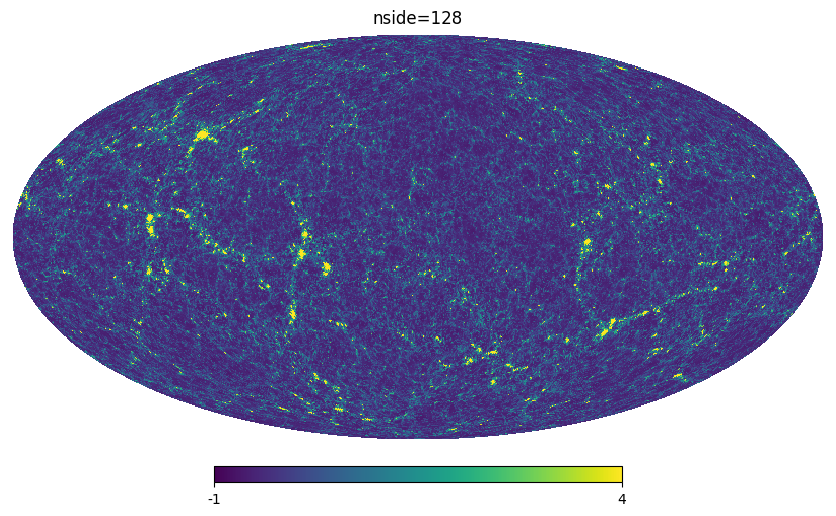

In [45]:
hp.mollview(I, min=-1, max=4, title=f'{nside=}')